# Lesson 2 : LangGraph Components

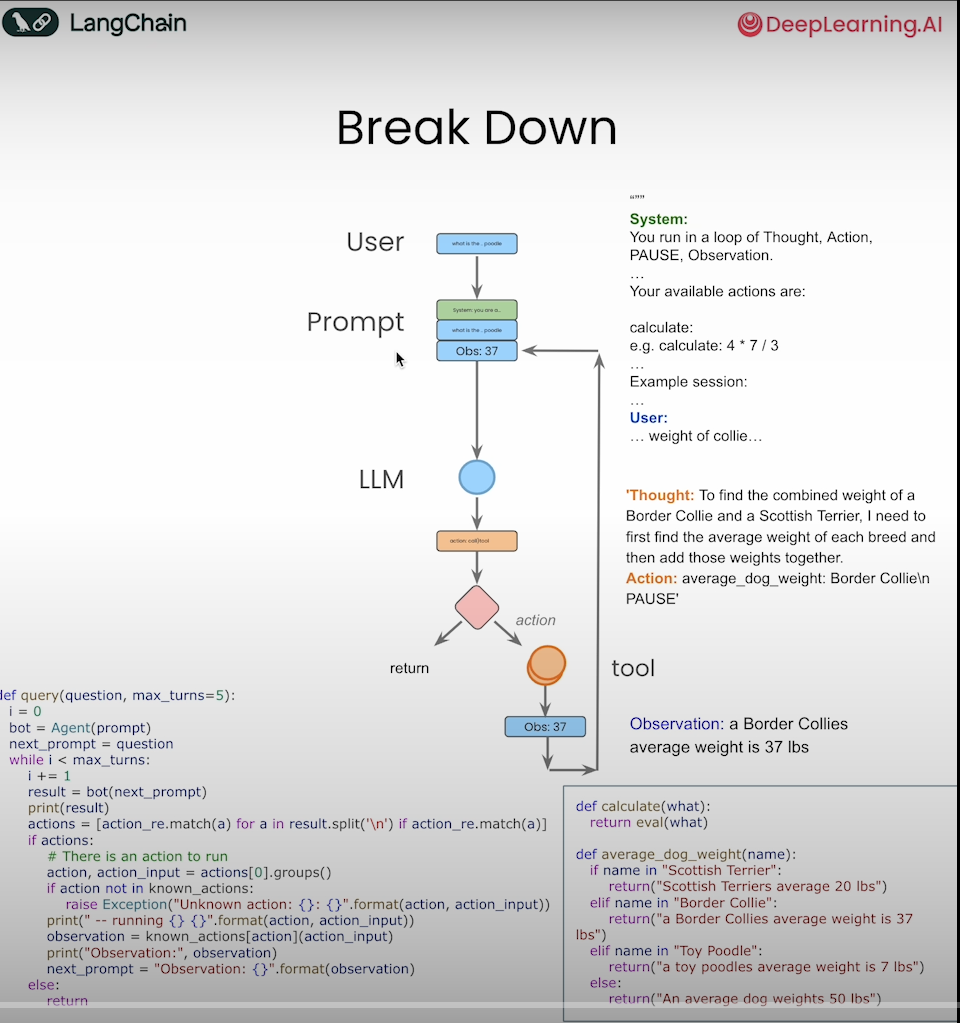

## Prompt Template 
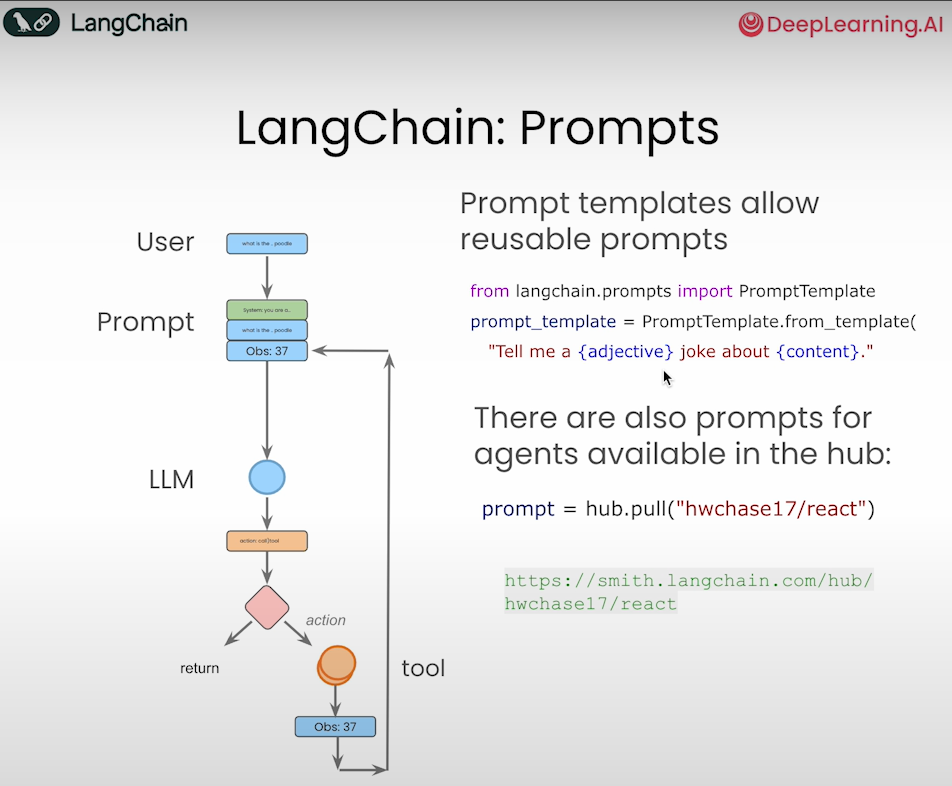

https://smith.langchain.com/hub/hwchase17/react


## Tools
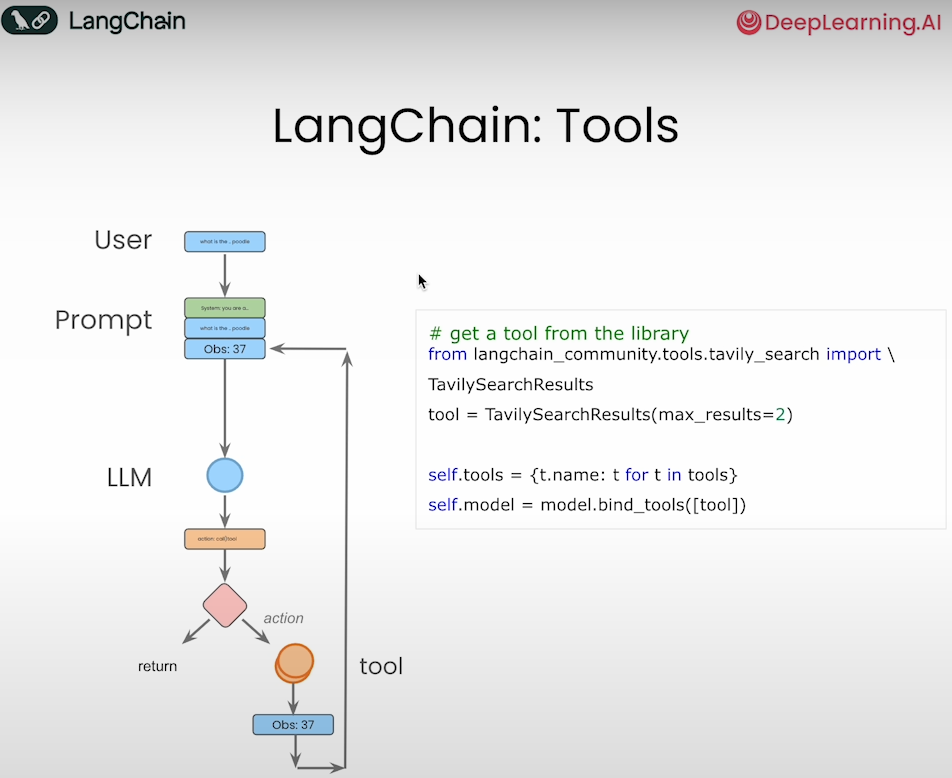

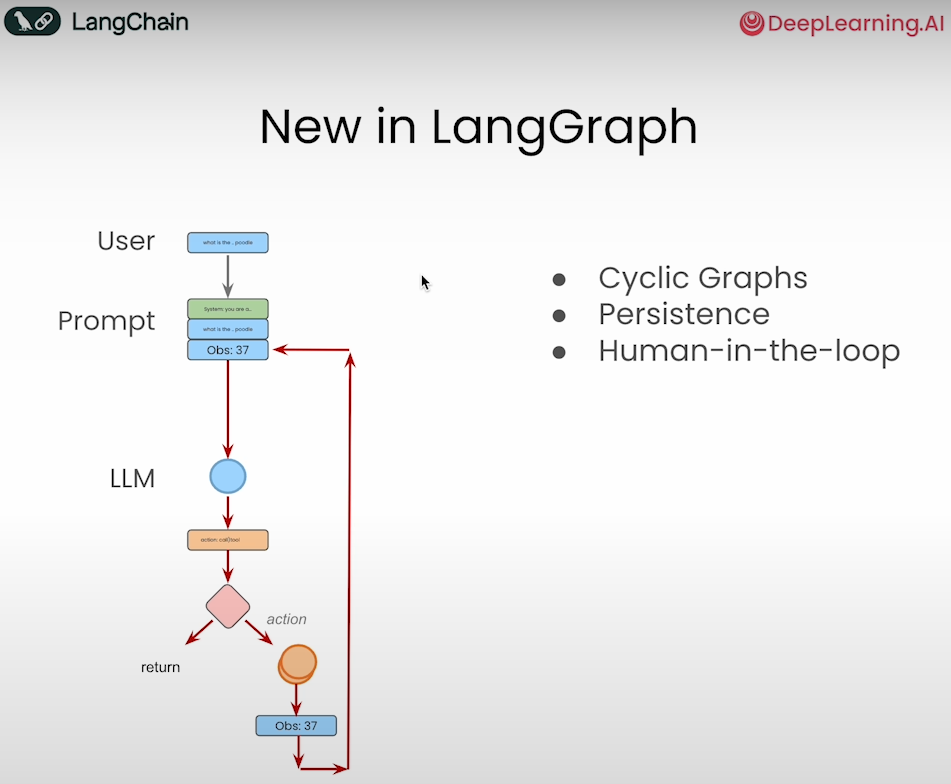

Maybe the biggest part of this application,
the most code that we wrote, was this function that would loop.
And that's represented by all these arrows, here.
And that's one way to think about LangGraph.

LangGraph helps you describe and orchestrate that control flow.
Specifically, it allows you to create cyclic graphs

It also comes with built-in persistence.
And this is really nice for having multiple conversations
at the same time, or remembering previous iterations and actions.
This persistence also enables really cool human in the loop features.

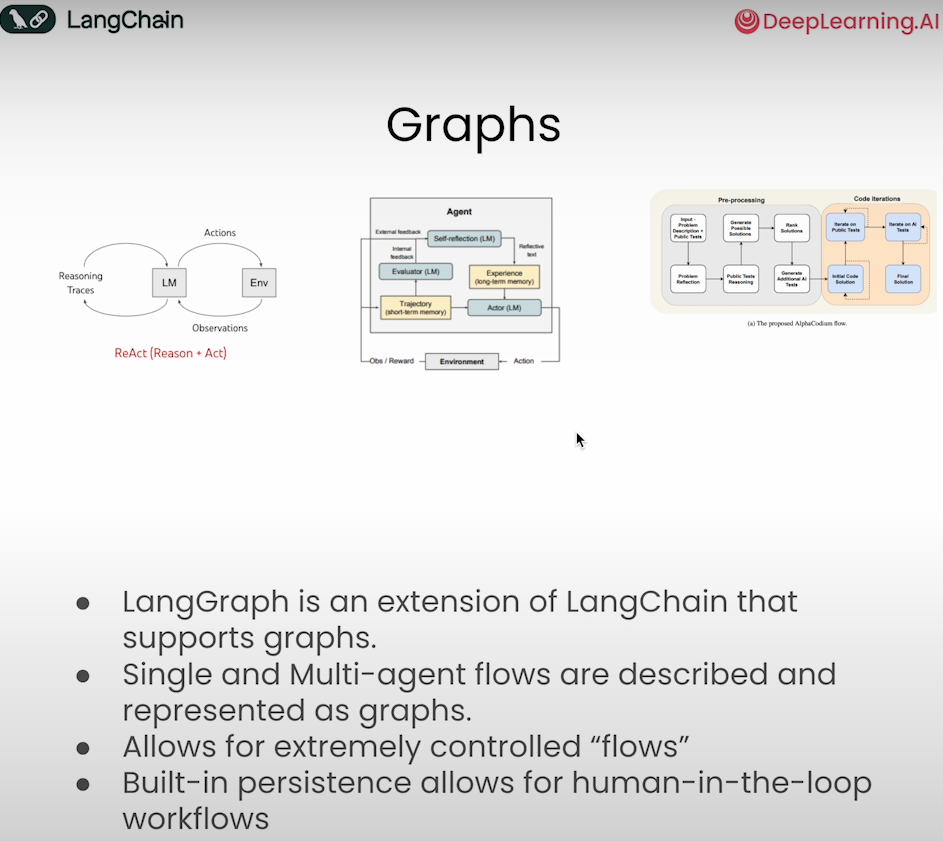

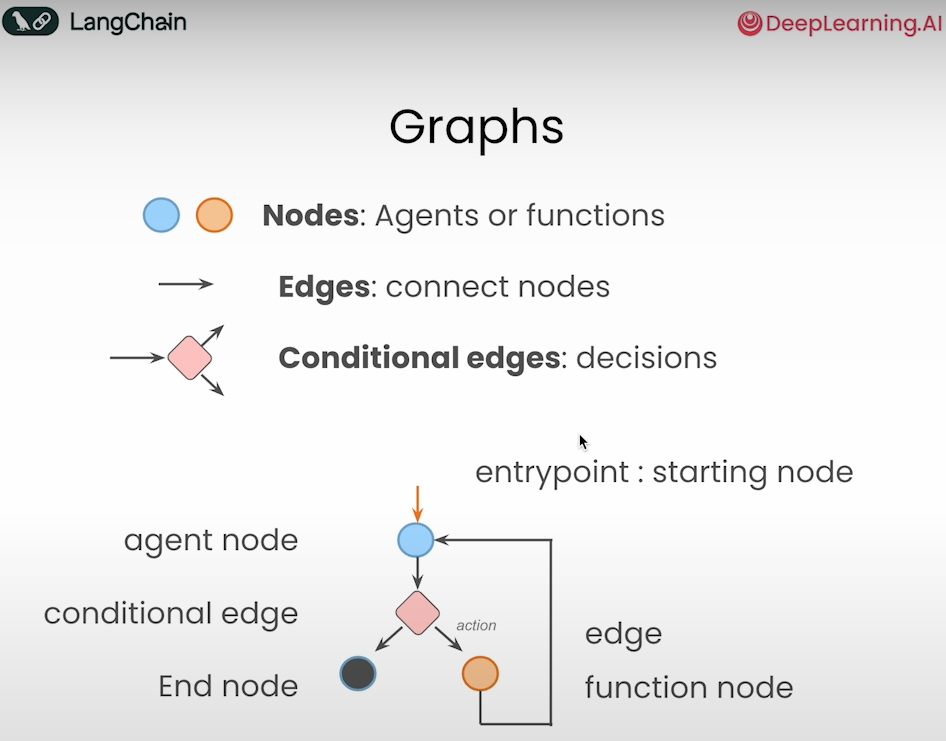

LangGraph are nodes, edges, and conditional edges.
Nodes are agents or functions.
Edges connect these nodes, and then conditional edges are used
when you need to make decisions about which node you should go to next.

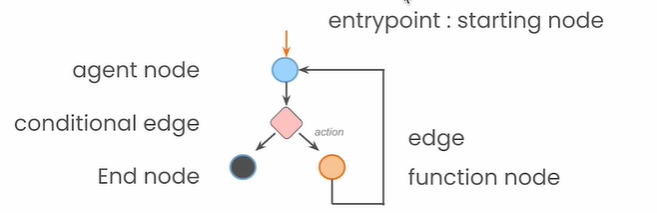

We can have an agent node. This is the LLM.

We can then have a conditional edge which takes the result
of that LLM call and decides what to do next.

One of those edges can be an action edge which calls a function node,
and that automatically loops back to the agent node.

There's an entry point, which is where you start, and then there's
the end node, which is the other action available to take after the agent.

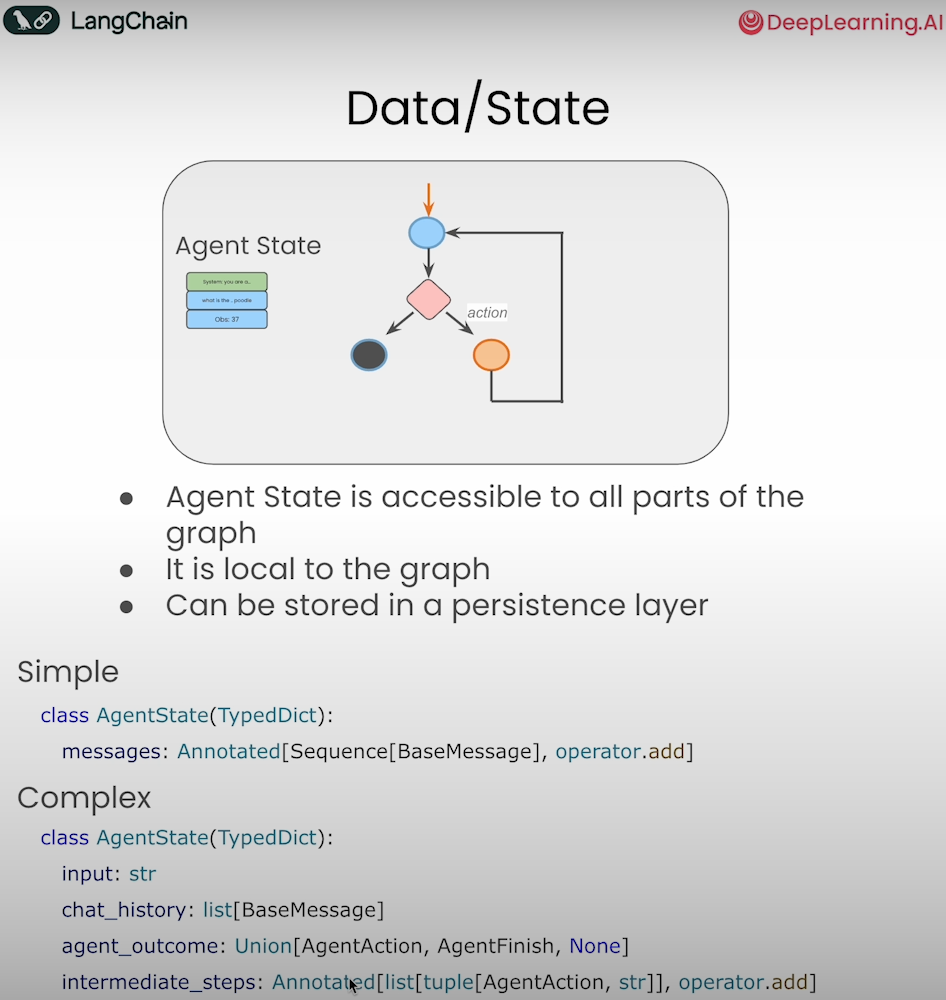

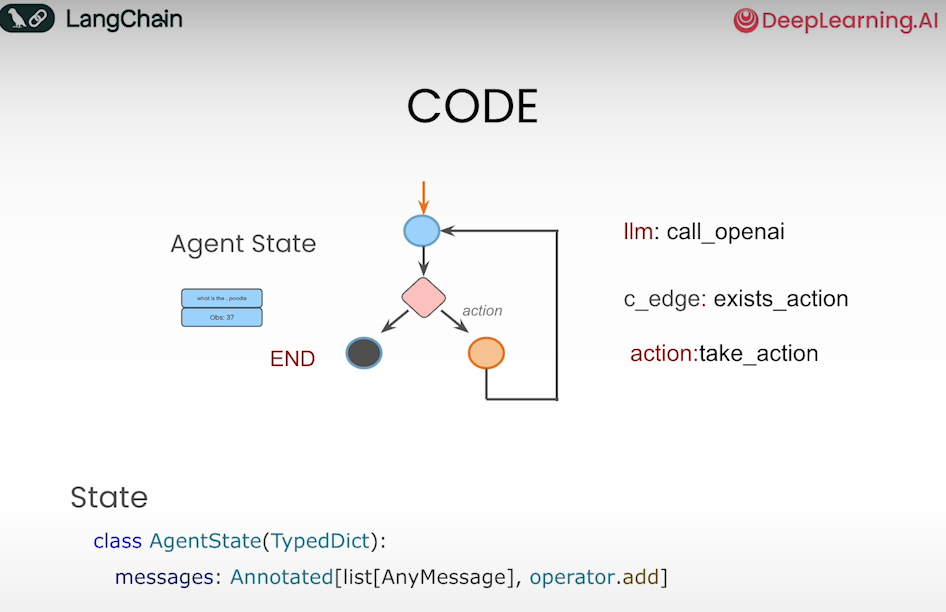

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

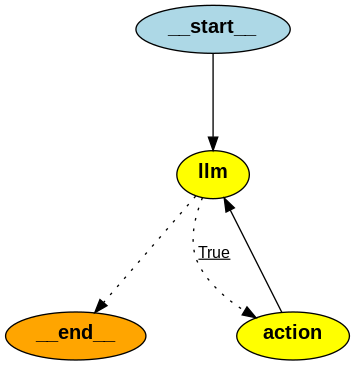

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_fo9D2p2hhh6hNLCHf0wDKNzm'}
Back to the model!


In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fo9D2p2hhh6hNLCHf0wDKNzm', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ac39076c-89bb-4178-ab30-5815ff15d6f0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_fo9D2p2hhh6hNLCHf0wDKNzm'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/

In [10]:
result['messages'][-1].content

'The current weather in San Francisco is 63.0°F with clear skies. The wind speed is 9.4 kph coming from the southwest direction. The humidity is at 81%.'

In [11]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_s1pVhGYMR3vy6aumeUp3FmBn'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_eaqN2HUuOeoGDWCd1RId2aGo'}
Back to the model!


In [12]:
result['messages'][-1].content

'The current weather in San Francisco is clear with a temperature of 63.0°F (17.2°C) and the wind blowing at 9.4 km/h from the southwest. In Los Angeles, it is also clear with a temperature of 66.9°F (19.4°C) and a gentle wind blowing at 7.9 km/h from the south-southeast.'

In [13]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_eEWo2lMuBf8JgFVYSsq8ORjJ'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters state'}, 'id': 'call_cAqvhI0hNbDdoKcbMhpeWo7W'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_Fwf8LD7pqZ16oKHzMBONfCQE'}
Back to the model!


In [14]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. **In what state is the winning team headquarters located?**
   - The headquarters of the Kansas City Chiefs is located in the state of Missouri.

3. **What is the GDP of that state?**
   - The GDP of Missouri for the year 2024 is not explicitly available, but as of 2022, Missouri's GDP was approximately $336.63 billion according to the U.S. Bureau of Economic Analysis.
